# **PPCT**

In [3]:
import scipy.stats
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm_notebook as pbar
from viz import MOResultsVisualizer
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import neurophox
from neurophox.numpy import *
from neurophox.tensorflow import *

from neurophox.ml import LinearMultiModelRunner

# Comment this out if you do not have latex (or associated requirements) installed
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Charter']})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

import warnings
from collections import namedtuple

warnings.filterwarnings('ignore')

# neurophox imports

# test_mesh = interactive(RMNumpy, units=(1,5))
# test_mesh.plot()


'random_theta'

Text(0.5, 1.0, 'Propagation for 64x64 random_theta')

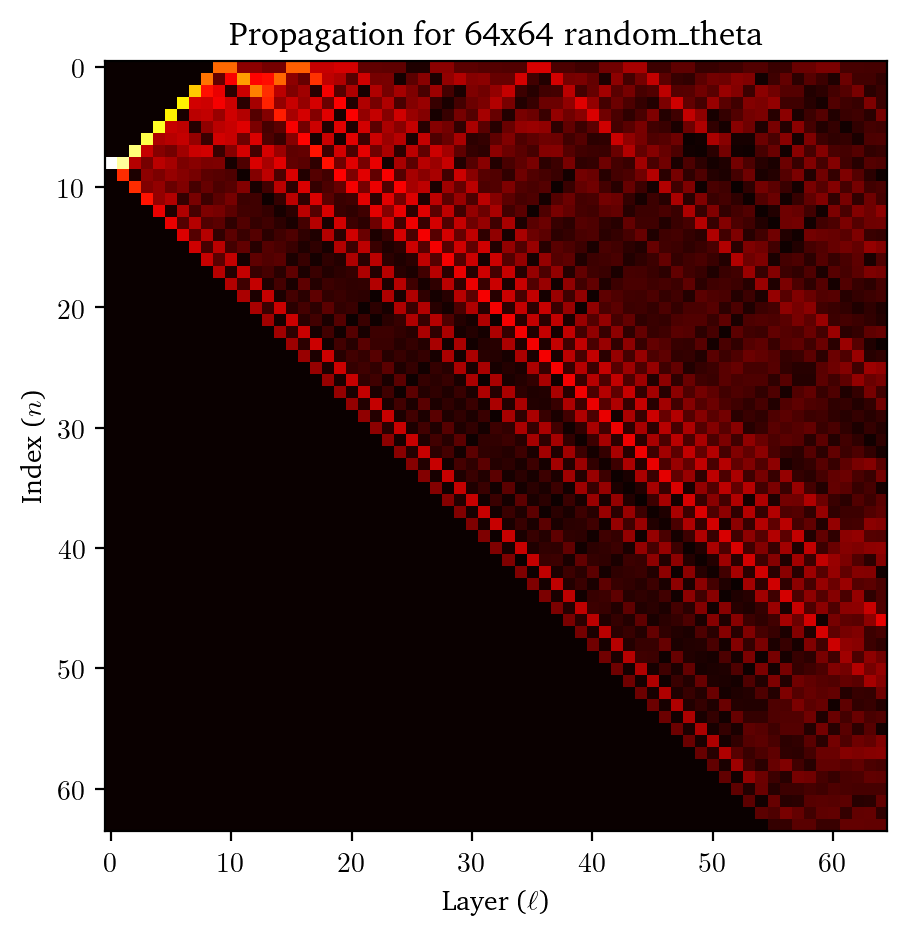

In [6]:
#single mvm test
max = 128
min = 3
test_mesh = 0
units = max // 2
num_layers = units
rng = np.random.default_rng(0xdeadbeef)
test_val = rng.integers(0, units)
# init_method = widgets.Dropdown(options=['haar_rect', 'random_theta']).value
init_method = 'random_theta'
display(init_method)
# @interact(units=(3,128), num_layers=(3,128), test_val=(0,max))

# def gen_test_mesh(units,num_layers,test_val):
test_mesh = RMNumpy(units, num_layers=num_layers, phi_init=init_method)
# test_mesh.plot(plt)

plt.figure(dpi=200, figsize=(10, 5))
plt.imshow(np.abs(test_mesh.propagate(np.eye(units)[test_val]).squeeze()).T, cmap='hot')
plt.ylabel("Index ($n$)")
plt.xlabel("Layer ($\ell$)")
plt.title(f'Propagation for {units}x{num_layers} {init_method}')

# gammavals = np.array(  [[4.73716227, 2.17789493, 6.00926144]] )
# thetavals = np.array(  [[4.73716227, 2.17789493, 6.00926144, 1,1]] )
# phivals = np.array(  [[4.73716227, 2.17789493, 6.00926144,1,1]] )

In [7]:
arbitrary_multiply_matrix = scipy.stats.unitary_group.rvs(units,random_state=rng,)
Dataset = namedtuple('Dataset', ['X', 'y'])
for i in range(arbitrary_multiply_matrix.shape[0]):
    num = rng.random(1, np.floating)
    arbitrary_multiply_matrix[i][i] = num.astype(np.float64)
X = []
Y = []
for i in range(20):
    x = rng.random((units,units), dtype=np.floating)
    y = x * arbitrary_multiply_matrix
    X.append(x)
    Y.append(y.astype(np.float64))
arbitrary_multiply_matrix = arbitrary_multiply_matrix.astype(np.float64)

print(type(arbitrary_multiply_matrix[0][0]))

<class 'numpy.float64'>


In [9]:
HIGH_RATE = 0.01
LOW_RATE = 0.002
mr = LinearMultiModelRunner(experiment_name=f"rm-prm-",
                            layer_names=["layer0"],
                            layers= [RM(units, num_layers=num_layers,phi_init=init_method)],
                            batch_size = 20,
                            optimizer=tf.keras.optimizers.Adam(learning_rate=HIGH_RATE),
                            logdir="/tmp/tensorboard/neurophox/")
%load_ext tensorboard
%tensorboard --logdir /tmp/tensorboard/neurophox  --host 0.0.0.0 --reload_interval 2
mr.run(50, arbitrary_multiply_matrix, pbar)



  0%|          | 0/2500 [00:00<?, ?it/s]

ValueError: Invalid dtype: complex64

In [ ]:
print(dir(mr))
print(f'loss : {mr.losses["layer0"][len(mr.losses["layer0"])-1]}')
plt.figure()
fig, axes = plt.subplots(2, 2, dpi=500)

viz = MOResultsVisualizer('rm', mr.results["layer0"])
viz.plot_theta_checkerboard(axes[0, 0], plt, -1)
viz.plot_error(axes[0, 1], plt, -1)

#axes[1, 0].text(-0.2, 1.1, r'(\textbf{d})', transform=axes[0, 0].transAxes, size=10)